# Train Classifiers

Use huggingface transformers to train a couple classification model's and compare performance. We need the best performance possible while also taking into consideration the compute requirements of the model. Ideally, the model should run on CPU-only or serve predictions from a remote endpoint.

Let's train a handful of models in increasing computational / model complexity and compare performance. Given the extreme imbalance in classes, performance will likely be poor across the board. 

DistilBERT is one transformer option. However, due to the max token size of 512, many of the examples will be significantly truncated. Let's see whether this affects performance. We can try to work around imbalance by using upsampling on the feature space. 

We'll fit the following models:
- DistilBERT Feature Embeddings & Longformer Feature Embeddings X SMOTE upsampling X 3 different classification100 heads:
    1. Logistic Regression
    2. SVM
    3. XG Boost
- DistilBERT fine-tuned (no upsampling) 
- Longformer fine-tuned (no upsampling)

That comes to a total of 8 different models.

## Prep data for Embeddings

In [6]:
from boxsdk import OAuth2, DevelopmentClient
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, load_from_disk
from joblib import dump
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from imblearn.combine import SMOTEENN
from collections import Counter
import configparser
import glob
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
import pandas as pd

In [7]:
# Setup box client
# Read in configuration variables
parser = configparser.ConfigParser()
parser.read("../pipeline.conf")

# Create client
client = DevelopmentClient()

In [8]:
# Retrieve mediation project folder info
folder_id = parser.get("umd_box_credentials", "OTHER_DOCUMENTS_FOLDER_ID")
other_documents_folder = client.folder(folder_id=folder_id).get()

# Get or create curation pipeline folder
already_created = 'Curation-Pipeline' in [folder.name for folder in other_documents_folder.item_collection['entries']]
if not already_created:
    curation_pipeline = other_documents_folder.create_subfolder('Curation-Pipeline')
    print(f"Created project subfolder with ID {curation_pipeline.id}")
else:
    folder_id = [item.id for item in other_documents_folder.item_collection['entries'] if item.name == 'Curation-Pipeline'][0]
    curation_pipeline = client.folder(folder_id).get()
    
# get or create models folder
already_created = 'Models' in [folder.name for folder in curation_pipeline.item_collection['entries']]
if not already_created:
    models_folder = curation_pipeline.create_subfolder('Models')
    print(f"Created models subfolder with ID {models_folder.id}")
else:
    folder_id = [item.id for item in curation_pipeline.item_collection['entries'] if item.name == 'Models'][0]
    models_folder = client.folder(folder_id).get()

GET https://api.box.com/2.0/folders/144471021827 {'headers': {'Authorization': '---yPG0',
             'User-Agent': 'box-python-sdk-3.4.0',
             'X-Box-UA': 'agent=box-python-sdk/3.4.0; env=python/3.10.4'},
 'params': None}
"GET https://api.box.com/2.0/folders/144471021827" 200 2639
{'Date': 'Thu, 01 Sep 2022 21:43:50 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'x-envoy-upstream-service-time': '176', 'etag': '"1"', 'box-request-id': '0f29193d87d33c80d50b08f6a4753dc0c', 'cache-control': 'no-cache, no-store', 'strict-transport-security': 'max-age=31536000', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"'}
{'content_created_at': '2021-08-28T08:00:07-07:00',
 'content_modified_at': '2022-09-01T14:35:13-07:00',
 'created_at': '2021-08-28T08:00:07-07:00',
 'created_by': {'id': '15074227686',
               

In [9]:
# Retrieve data folder and get download urls for datasets
dataset_paths = glob.glob('../data/mediation_search_results*csv')
if len(dataset_paths) < 2:
    data_id = [item.id for item in curation_pipeline.item_collection['entries'] if item.name == 'Data'][0]
    data_folder = client.folder(data_id).get()

    for item in data_folder.get().item_collection['entries']:
        if 'mediation_search_results' in item.name:
            with open(os.path.join('../data', item.name), 'wb') as output_file:
                client.file(item.id).download_to(output_file)

# Create hugging face dataset
base_path = '../data/mediation_search_results'
data_files = {
    'train': f"{base_path}-train.csv",
    'test': f"{base_path}-test.csv"
}
mediations = load_dataset('csv', data_files=data_files)

GET https://api.box.com/2.0/folders/170494678795 {'headers': {'Authorization': '---yPG0',
             'User-Agent': 'box-python-sdk-3.4.0',
             'X-Box-UA': 'agent=box-python-sdk/3.4.0; env=python/3.10.4'},
 'params': None}
"GET https://api.box.com/2.0/folders/170494678795" 200 2662
{'Date': 'Thu, 01 Sep 2022 21:44:00 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'x-envoy-upstream-service-time': '227', 'etag': '"1"', 'box-request-id': '052cf184b1d02753dd9c2daad460090ed', 'cache-control': 'no-cache, no-store', 'strict-transport-security': 'max-age=31536000', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"'}
{'content_created_at': '2022-08-24T11:07:46-07:00',
 'content_modified_at': '2022-09-01T14:35:13-07:00',
 'created_at': '2022-08-24T11:07:46-07:00',
 'created_by': {'id': '17101481913',
               

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1521.05it/s]


Dataset csv downloaded and prepared to /home/evan/.cache/huggingface/datasets/csv/default-0733b41dfe0fb675/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 406.44it/s]


In [4]:
model_dbert = "distilbert-base-uncased"
model_lformer = "allenai/longformer-base-4096"
models = [model_dbert, model_lformer]

In [49]:

# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dbert)

# Tokenizer util
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

mediations_encoded = mediations.map(tokenize, batched=True, batch_size=None)

In [3]:
# Creat model
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "cpu"
    )
model = AutoModel.from_pretrained(model_lformer).to(device)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Extract hidden states
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hideen states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

# Convert mediations data to torch format
mediations_encoded.set_format("torch",
                              columns=["input_ids", "attention_mask", "label"])

mediations_hidden = mediations_encoded.map(extract_hidden_states, batched=True, batch_size=8)

  0%|          | 0/3898 [00:00<?, ?ba/s]

In [13]:
# Save to disk
model_outfile = f"../models/{model_lformer}-feature-embeddings"
mediations_hidden.save_to_disk(model_outfile)

In [4]:
model_outfile = f"../models/{model_lformer}-feature-embeddings"
mediations_hidden = load_from_disk(model_outfile)

## Create splits and up/down sample embeddings for imbalanced data

In [10]:
# Create splits
X_train = np.array(mediations_hidden["train"]["hidden_state"])
X_valid = np.array(mediations_hidden["test"]["hidden_state"])
y_train = np.array(mediations_hidden["train"]["label"])
y_valid = np.array(mediations_hidden["test"]["label"])

X_train.shape, X_valid.shape

((72754, 768), (31181, 768))

In [12]:
# Under-sample majority class and up-sample mintory class
seed = 123
smote_enn = SMOTEENN(random_state=seed, n_jobs=20)
X_train_re, y_train_re = smote_enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_re).items()))

[(0, 62073), (1, 71717)]


In [13]:
# Visualizing the training set
# Scale features to [0,1] rage
X_scaled = MinMaxScaler().fit_transform(X_train_re)

# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train_re
df_emb.head()

NameError: name 'pd' is not defined

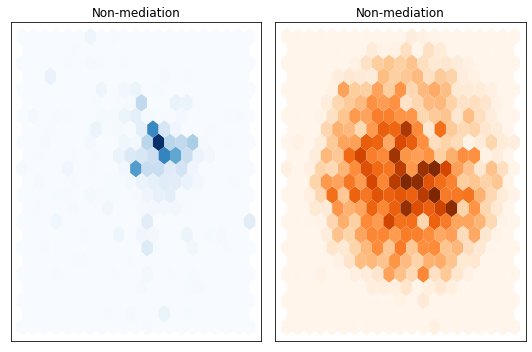

In [17]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(7.5,5))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = list(np.where(df_emb["label"] == 0, 'Non-mediation', 'Mediation'))

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label ==  {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Train Classifier Heads

In [19]:
# Training models
n_jobs = 20
scores = {}

#
# Logistic Regression
#
lr_clf = LogisticRegression(max_iter=3000, n_jobs=n_jobs) # Increase max iter to ensure convergence
lr_clf.fit(X_train_re, y_train_re)
lr_score = lr_clf.score(X_valid, y_valid)
scores['logistic'] = lr_score

# #
# # Support Vector machine
# #
# svm_clf = SVC(C=1, kernel='rbf', gamma=10, max_iter=3000, n_jobs=n_jobs)
# svm_clf.fit(X_scaled, y_train_re)
# X_val_scaled = MinMaxScaler().fit_transform(X_valid)
# svm_score = svm_clf.score(X_val_scaled, y_valid)
# scores['svm'] = svm_score

# #
# # Baseline
# #
# dummy_clf = DummyClassifier(strategy="stratified")
# dummy_clf.fit(X_train_re, y_train_re)
# dummy_score = dummy_clf.score(X_valid, y_valid)
# scores['baseline'] = dummy_score

# scores

In [5]:
# Confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels, subtitle=None):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title(f"Normalized confusion matrix\n{subtitle}")
    plt.show()

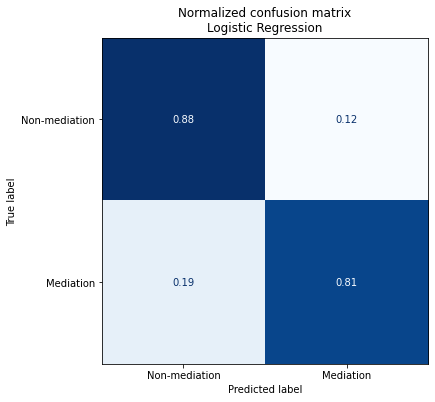

In [21]:
# Confusion matrix for Logistic Regression
labs = ['Non-mediation', 'Mediation']
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labs, 'Logistic Regression')

In [29]:
X_valid[0].shape

(768,)

In [ ]:
# Confusion mattrix for SVM
y_preds = svm_clf.predict(X_val_scaled)
plot_confusion_matrix(y_preds, y_valid, labs, 'SVM')

In [22]:
# Save logistic regresion model
outfile = '../models/longformer-base-4096-mediations-logistic-classifier.joblib'
with open(outfile, 'wb') as f:
    dump(lr_clf, f)

In [18]:
# Upload classifier heads
classifier_heads = glob.glob('../models/*.joblib')

for path in classifier_heads:
    uploaded_file = client.folder(models_folder.id).upload(path)
    print(f'File "{uploaded_file.name}" uploaded to Box with file ID {uploaded_file.id}')
    

POST https://upload.box.com/api/2.0/files/content {'data': <MultipartEncoder: OrderedDict([('attributes', '{"name": "longformer-base-4096-mediations-logistic-classifier.joblib", "parent": {"id": "170499054839"}, "description": null, "content_created_at": null, "content_modified_at": null}'), ('file', ('unused', <_io.BufferedReader name='../models/longformer-base-4096-mediations-logistic-classifier.joblib'>))])>,
 'headers': {'Authorization': '---PQ0e',
             'Content-Type': 'multipart/form-data; '
                             'boundary=63bbcee2d7a34f19ad88211c3157f792',
             'User-Agent': 'box-python-sdk-3.4.0',
             'X-Box-UA': 'agent=box-python-sdk/3.4.0; env=python/3.10.4'}}
"POST https://upload.box.com/api/2.0/files/content" 201 1384
{'Server': 'nginx', 'Date': 'Wed, 24 Aug 2022 19:45:50 GMT', 'Content-Type': 'application/json', 'Content-Length': '1384', 'Cache-Control': 'no-cache, no-store', 'X-Envoy-Upstream-Service-Time': '976', 'Strict-Transport-Security'

## Fine-Tune DistilBert

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, brier_score_loss, accuracy_score
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch import nn

In [ ]:
# Calculate weights for imbalanced classes
y = np.array(mediations_encoded['train']['label'])
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

In [ ]:
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_dbert, num_labels=num_labels)
         .to(device))

# Define performance metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    brier = brier_score_loss(labels, preds)
    acc = accuracy_score(labels, preds)
    return { "f1": f1, "brier": brier }


In [ ]:
# Login to hub via huggingface-cli login
# Set Training parameters
batch_size = 16
logging_steps = len(mediations_encoded["train"]) // batch_size
model_name = f"{model_dbert}-finetuned-mediations"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.1,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

# Custom Trainer for imbalanced classes
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # Forward pasas
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights).cuda()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Train
trainer = CustomTrainer(model=model, args=training_args,
                   compute_metrics=compute_metrics,
                   train_dataset=mediations_encoded["train"],
                   eval_dataset=mediations_encoded["test"],
                   tokenizer=tokenizer)
trainer.train()

In [ ]:
# Get predictions
preds_output = trainer.predict(mediations_encoded["test"])
preds_output.metrics

In [ ]:
# Confusion matrix
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(mediations_encoded["test"]["label"])
plot_confusion_matrix(y_preds, y_valid, labs, 'DistilBERT Fine-Tuned')